# Zone Temperature Dynamical Model

Goals:
- investigate different physics-informed dynamical models for zone temperature prediction
- thermal dynamics should be captured

In [3]:
from jax import config 
config.update("jax_debug_nans", False)
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

import jax 
import jax.numpy as jnp 
import flax.linen as nn
import optax 
import pandas as pd 

from dynax.core.base_block_state_space import BaseContinuousBlockSSM
from dynax.simulators.simulator import DifferentiableSimulator
from dynax.trainer.train_state import TrainState

## 0. Data and DataLoader
- EP data with prototypical building model
- Real data from Lennox thermostat data

In [4]:
"""
import pandas as pd 

dates = ['01-'+str(i)+'-18' for i in range(14, 28)]
data = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)

combined_data = pd.DataFrame()
for key in data.keys():
    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)

combined_data.to_csv('./data/real-world-data.csv')
"""

"\nimport pandas as pd \n\ndates = ['01-'+str(i)+'-18' for i in range(14, 28)]\ndata = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)\n\ncombined_data = pd.DataFrame()\nfor key in data.keys():\n    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)\n\ncombined_data.to_csv('./data/real-world-data.csv')\n"

In [5]:
data = pd.read_csv('./data/real-world-data.csv')

columns_mapper = {'LocalTime':'time', 'tabtsense0':'temp_zone', 'SP_cool':'csp', 'SP_heat':'hsp', 'CoolDemand':'qcool', 'HeatDemand':'qheat', 'humidityindoor_0':'rh_zone', 'oupresentcompressorfreq':'freq', 'iuairflowrate':'cfm', 'surf_tempf':'temp_out', 'rad':'qsol'}

data = data[columns_mapper.keys()].rename(columns = columns_mapper)
data.index = pd.DatetimeIndex(data['time'], freq='1min')
data = data.drop(columns=['time'])


In [6]:
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol
time,,,,,,,,,,
2018-01-14 18:01:00,69.6,77,70,0,100,35.5,NaN,0,41.531667,0.0
2018-01-14 18:02:00,69.5,77,70,0,100,36.0,NaN,0,41.563333,0.0
2018-01-14 18:03:00,69.5,77,70,0,100,36.0,NaN,0,41.595000,0.0
2018-01-14 18:04:00,69.6,77,70,0,100,36.0,NaN,0,41.626667,0.0
2018-01-14 18:05:00,69.6,77,70,0,100,36.0,NaN,0,41.658333,0.0


This data is from Rohini's house, which has a Lennox thermostat but Carrier unit. Thus the equipment info are basically not available. 
- assume nominal heating capacity is 4 ton (e.g., 14 kW)

In [7]:
# change IP unit to SI
# F to C
data[['temp_zone', 'csp', 'hsp', 'temp_out']] =  5./9*(data[['temp_zone', 'csp', 'hsp', 'temp_out']] - 32)
# W to kW
data['qsol'] /= 1000.
# percentage to kW
data[['qcool', 'qheat']] *= 14./100.

data['qhvac'] = -1*data['qcool'] + data['qheat']

In [8]:
# resampel to 15min 
data = data.resample('15min').mean()
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol,qhvac
time,,,,,,,,,,,
2018-01-14 18:00:00,21.206349,25.0,21.111111,0.0,7.0,35.178571,NaN,0.0,5.409722,0.0,7.0
2018-01-14 18:15:00,21.618519,25.0,21.111111,0.0,0.0,33.733333,NaN,0.0,5.664815,0.0,0.0
2018-01-14 18:30:00,21.329630,25.0,21.111111,0.0,0.0,35.333333,NaN,0.0,5.928704,0.0,0.0
2018-01-14 18:45:00,21.125926,25.0,21.111111,0.0,0.0,36.000000,NaN,0.0,6.192593,0.0,0.0
2018-01-14 19:00:00,21.118519,25.0,21.111111,0.0,0.0,36.333333,NaN,0.0,6.268519,0.0,0.0


In [9]:
# time features
def add_time_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    return data

# use cos and sin to encode cyclical features
def encode_cyclical(data, col, max_val):
    data[col+'_sin'] = np.sin(2*np.pi*data[col]/max_val)
    data[col+'_cos'] = np.cos(2*np.pi*data[col]/max_val)
    return data


In [10]:
target_col = ["temp_zone"]
outdoor_col = ["temp_out", "qsol"]
control_col = ["qhvac"]
feature = target_col + outdoor_col + control_col

data = data[feature]

# add time features
data = add_time_features(data)
data = encode_cyclical(data, "hour", 23)
data = encode_cyclical(data, "dayofweek", 6)
time_feature = ["hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos"]

data = data[feature + time_feature]
data.head()

,temp_zone,temp_out,qsol,qhvac,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
time,,,,,,,,
2018-01-14 18:00:00,21.206349,5.409722,0.0,7.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:15:00,21.618519,5.664815,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:30:00,21.329630,5.928704,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 18:45:00,21.125926,6.192593,0.0,0.0,-0.979084,0.203456,-2.449294e-16,1.0
2018-01-14 19:00:00,21.118519,6.268519,0.0,0.0,-0.887885,0.460065,-2.449294e-16,1.0


#### Prepare Data

`states`: $T_z$

`inputs`: $(\dot q_{hvac}|_{t}^{t+H}, (t, \dot q_{sol}, T_{out})|_{t-P}^{t+H})$

In [11]:
# lag features 
n_lags = 1
n_futures = 1

# shift for future steps
target = data[target_col].shift(-n_futures)
target.columns = [col+'_next' for col in target.columns]
data = pd.concat([data, target], axis=1).dropna()

# split for training and validation and testing
split_ratio = [0.7, 0.15, 0.15]
n_samples = data.shape[0]
n_train = int(n_samples * split_ratio[0])
n_val = int(n_samples * split_ratio[1])
n_test = n_samples - n_train - n_val

train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train+n_val]
test_data = data.iloc[n_train+n_val:]



## 1. Models



In [12]:
def mse(y_true, y_pred):
    return jnp.mean(jnp.square(y_true - y_pred))

def rmse(y_true, y_pred):
    return jnp.sqrt(mse(y_true, y_pred))


### 1.1 Baseline Model

This model simply predicts the next steo using the current step value

In [13]:
# train loss
y_pred_train = train_data[target_col].values
y_target_train = train_data[[col+'_next' for col in target_col]].values
mse_train = mse(y_target_train, y_pred_train)
rmse_train = rmse(y_target_train, y_pred_train)

# val loss
y_pred_val = val_data[target_col].values
y_target_val = val_data[[col+'_next' for col in target_col]].values
mse_val = mse(y_target_val, y_pred_val)
rmse_val = rmse(y_target_val, y_pred_val)

# test loss 
y_pred_test = test_data[target_col].values
y_target_test = test_data[[col+'_next' for col in target_col]].values
mse_test = mse(y_target_test, y_pred_test)
rmse_test = rmse(y_target_test, y_pred_test)

print("Baseline model: ")
print(f"Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f}, Test MSE: {mse_test:.4f}")
print(f"Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}, Test RMSE: {rmse_test:.4f}")


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Baseline model: 
Train MSE: 0.0591, Val MSE: 0.0736, Test MSE: 0.0391
Train RMSE: 0.2431, Val RMSE: 0.2713, Test RMSE: 0.1978


### 1.2 Physics-informed Neural ODE

In this section, I will use physics-informed neural networks to model the zone temperature dynamics.
The physics is modeled by a typical 2R2C model, and the neural network is used to approximate the unknown dynamics.

The following equation describes a typical 2R2C model for zone temperature dynamics:

$$
\begin{align*}

\begin{bmatrix}
    \dot T_r \\
    \dot T_m
\end{bmatrix}
= 
\begin{bmatrix}
    -(\frac{1}{C_rR_{ra}} + \frac{1}{C_rR_{rm}}) & \frac{1}{C_rR_{rm}} \\
    \frac{1}{C_mR_{rm}} & -\frac{1}{C_mR_{rm}}
\end{bmatrix} 
\begin{bmatrix}
    T_r \\
    T_m
\end{bmatrix}
+ 
\begin{bmatrix}
    b \\
    0
\end{bmatrix}
u
+ 
\begin{bmatrix}
    \frac{\alpha}{C_r} \frac{\beta}{C_r} \frac{1}{C_rR_{ra}} \\
    \frac{1-\alpha}{C_m} \frac{1-\beta}{C_m} 0
\end{bmatrix} 
\begin{bmatrix}
    G \\
    I_g \\
    T_a
\end{bmatrix}

\end{align*}
$$



we use this structure to encode laten space dynamics and use neural networt to approximate the unknown dynamics

notations:
- **latent state**: $z$
- **observable variables**: $x$
- **control input**: $u$
- **disturbance**: $d$

$$ z_{i} = f(x_i^p, x_i, u_i, d_i) $$
$$ x_{i+1} = g(x_i^p, x_i, u_i, d_i) $$

For the simple RC zone model, $z$ can be $T_m$, $x$ can be $T_r$. If we know $\dot T_r$, we can estimate $T_{m, i}$ based on the following prior:

$$
\begin{align*}

\begin{bmatrix}
    \dot T_r \\
    \dot T_m
\end{bmatrix}
= 
\begin{bmatrix}
    -a_{11} & a_{12} \\
    a_{21} & -a_{22}
\end{bmatrix} 
\begin{bmatrix}
    T_r \\
    T_m
\end{bmatrix}
+ 
\begin{bmatrix}
    b \\
    0
\end{bmatrix}
u
+ 
\begin{bmatrix}
    c_{11} c_{12} c_{13} \\
    c_{21} c_{22} 0
\end{bmatrix} 
\begin{bmatrix}
    0 \\
    0 \\
    T_a
\end{bmatrix}

\end{align*}
$$

So 

the target $$ T_{m, i} = \frac{1}{a_{12}} (\dot T_{r, i} + a_{11} T_{r,i} + b u_i - c_{13} T_{a,i}) $$

#### Define Model

In [37]:
class Model(nn.Module):
    state_dim: int
    obs_dim: int
    control_dim: int
    disturb_dim: int
    
    @nn.compact
    def __call__(self, prev_obs, curr_obs, u, d):
        # prev_state: (batch, n_past, obs_dim)
        # curr_state: (batch, obs_dim)
        # u: (batch, control_dim)
        # d: (batch, disturb_dim)

        # shared parameters
        B = prev_obs.shape[0]
        x = jnp.concatenate([prev_obs.reshape(B, -1), curr_obs, u, d], axis=-1)
        x = nn.Dense(8)(x)
        x = nn.relu(x)
        x = nn.Dense(8)(x)
        x = nn.relu(x)

        # head for latent state prediction
        z = nn.Dense(self.state_dim)(x)
        
        # head for observation prediction
        next_obs = nn.Dense(self.obs_dim)(x)

        # physics 
        a = self.param('a', nn.initializers.ones_init(), (1,2))
        b = self.param('b', nn.initializers.constant(0.1), ())
        c = self.param('c', nn.initializers.constant(0.1), ())

        z_target = 1/a[0, 1] * (next_obs - curr_obs + a[0, 0]*curr_obs - b*u - c*d[:, [-2]])
        
        return z, next_obs, z_target

In [38]:
model = Model(state_dim=1, obs_dim=1, control_dim=1, disturb_dim=6)

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((4, 4, 1)), jnp.ones((4, 1)), jnp.zeros((4, 1)), jnp.ones((4, 6)))
z_curr, next_obs, z_tar = model.apply(init_params, jnp.ones((4, 4, 1)), jnp.ones((4, 1)), jnp.zeros((4, 1)), jnp.ones((4, 6)))
print(z_curr.shape, next_obs.shape, z_tar.shape)
print(model.tabulate(key, jnp.ones((4, 4, 1)), jnp.ones((4, 1)), jnp.zeros((4, 1)), jnp.ones((4, 6))))

(4, 1) (4, 1) (4, 1)

                                 Model Summary                                  
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs           ┃ outputs        ┃ params                ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Model  │ - float32[4,4,1] │ - float32[4,1] │ a: float32[1,2]       │
│         │        │ - float32[4,1]   │ - float32[4,1] │ b: float32[]          │
│         │        │ - float32[4,1]   │ - float32[4,1] │ c: float32[]          │
│         │        │ - float32[4,6]   │                │                       │
│         │        │                  │                │ 4 (16 B)              │
├─────────┼────────┼──────────────────┼────────────────┼───────────────────────┤
│ Dense_0 │ Dense  │ float32[4,12]    │ float32[4,8]   │ bias: float32[8]      │
│         │        │                  │                │ kernel: float32[12,8] │
│     

#### Training and Evaluation

In [39]:
n_lags = 8
# get window data
def get_batch_data_at(batch_index, data_df, n_lags):
    prev_obs = data_df.iloc[batch_index-n_lags:batch_index][target_col].values
    curr_obs = data_df.iloc[batch_index][target_col].values
    u = data_df.iloc[batch_index][control_col].values
    d = data_df.iloc[batch_index][time_feature + outdoor_col].values
    t = data_df.iloc[batch_index][[col+'_next' for col in target_col]].values
    return prev_obs, curr_obs, u, d, t

# get batched data
def get_batch_data(idx, data_df, n_lags):
    prev_obs = []
    curr_obs = []
    u = []
    d = []
    targets = []
    for i in idx:
        pxi, xi, ui, di, ti = get_batch_data_at(i, data_df, n_lags)
        prev_obs.append(pxi)
        curr_obs.append(xi)
        u.append(ui)
        d.append(di)
        targets.append(ti)
    return jnp.array(prev_obs), jnp.array(curr_obs), jnp.array(u), jnp.array(d), jnp.array(targets)


# need reconstruct the data
n_lags = 8
n_train = train_data.shape[0]
n_val = val_data.shape[0]
n_test = test_data.shape[0]

batch_index_train = np.arange(n_lags, n_train)
prev_obs_train, curr_obs_train, u_train, d_train, t_train = get_batch_data(batch_index_train, data, n_lags)

batch_index_val = np.arange(n_train - n_lags, n_train+n_val)
prev_obs_val, curr_obs_val, u_val, d_val, t_val = get_batch_data(batch_index_val, data, n_lags)

batch_index_test = np.arange(n_train+n_val - n_lags, n_train+n_val+n_test)
prev_obs_test, curr_obs_test, u_test, d_test, t_test = get_batch_data(batch_index_test, data, n_lags)

print(prev_obs_train.shape, curr_obs_train.shape, u_train.shape, d_train.shape, t_train.shape)
print(prev_obs_val.shape, curr_obs_val.shape, u_val.shape, d_val.shape, t_val.shape)
print(prev_obs_test.shape, curr_obs_test.shape, u_test.shape, d_test.shape, t_test.shape)


(864, 8, 1) (864, 1) (864, 1) (864, 6) (864, 1)
(195, 8, 1) (195, 1) (195, 1) (195, 6) (195, 1)
(196, 8, 1) (196, 1) (196, 1) (196, 6) (196, 1)


In [40]:
# initialize model
model = Model(state_dim=1, obs_dim=1, control_dim=1, disturb_dim=6)

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((4, n_lags, 1)), jnp.ones((4, 1)), jnp.zeros((4, 1)), jnp.ones((4, 6)))

In [55]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, prev_obs, curr_obs, u, d, target):
    def loss_fcn(params):
        # prediction
        z, next_obs, zt = train_state.apply_fn(params, prev_obs, curr_obs, u, d)
        # regression loss
        reg_loss = jnp.mean((next_obs - target)**2)
        
        # physics related loss
        phys_loss = jnp.mean((z - zt)**2)

        # parameter range: a, b, c >= 0
        weight_loss = jnp.sum(nn.relu(-train_state.params['params']['a'])) + nn.relu(-train_state.params['params']['b']) + nn.relu(-train_state.params['params']['c'])

        return reg_loss + phys_loss + weight_loss
    
    loss, grad = jax.value_and_grad(loss_fcn)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state


@jax.jit
def test_step(train_state, prev_obs, curr_obs, u, d, target):
    def loss_fcn(params):
        # prediction
        z, next_obs, zt = train_state.apply_fn(params, prev_obs, curr_obs, u, d)
        # regression loss
        reg_loss = jnp.mean((next_obs - target)**2)
        
        # physics related loss
        phys_loss = jnp.mean((z - zt)**2)

        # parameter range: a, b, c >= 0
        weight_loss = jnp.sum(nn.relu(-train_state.params['params']['a'])) + nn.relu(-train_state.params['params']['b']) + nn.relu(-train_state.params['params']['c'])

        return reg_loss + phys_loss + weight_loss
    
    loss = loss_fcn(train_state.params)

    return loss

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(0.01)
)

train_state = TrainState.create(
    apply_fn=model.apply,
    params=init_params,
    tx = optim,
)


In [56]:
n_epochs = 8000

# train loop
steps = []
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, prev_obs_train, curr_obs_train, u_train, d_train, t_train)
    if epoch % 100 == 0:
        val_loss = test_step(train_state, prev_obs_val, curr_obs_val, u_val, d_val, t_val)
        test_loss = test_step(train_state, prev_obs_test, curr_obs_test, u_test, d_test, t_test)
        print(f"Epoch {epoch}, train_loss: {loss}, val_loss: {val_loss}, test_loss: {test_loss}")
    
    # save for plot
    steps.append(epoch)
    train_losses.append(loss)
    val_losses.append(val_loss)

Epoch 0, train_loss: 392.41058349609375, val_loss: 322.625, test_loss: 323.9670104980469
Epoch 100, train_loss: 0.472603440284729, val_loss: 0.537143886089325, test_loss: 0.26553910970687866
Epoch 200, train_loss: 0.19965673983097076, val_loss: 0.2458817958831787, test_loss: 0.13166341185569763
Epoch 300, train_loss: 0.12630337476730347, val_loss: 0.14749489724636078, test_loss: 0.09073453396558762
Epoch 400, train_loss: 0.10921728610992432, val_loss: 0.11952347308397293, test_loss: 0.0790858119726181
Epoch 500, train_loss: 0.10119019448757172, val_loss: 0.10856372863054276, test_loss: 0.07328624278306961
Epoch 600, train_loss: 0.08391544222831726, val_loss: 0.09260911494493484, test_loss: 0.05817782133817673
Epoch 700, train_loss: 0.07922527939081192, val_loss: 0.0877995491027832, test_loss: 0.05513406917452812
Epoch 800, train_loss: 0.07563420385122299, val_loss: 0.08455430716276169, test_loss: 0.05280148237943649
Epoch 900, train_loss: 0.07265084236860275, val_loss: 0.08210106194019

In [70]:
z_pred, y_pred, zt_pred = model.apply(train_state.params, prev_obs_train, curr_obs_train, u_train, d_train)
z_pred_test, y_pred_test, zt_pred_test = model.apply(train_state.params, prev_obs_test, curr_obs_test, u_test, d_test)

In [71]:
mse_train = mse(t_train, y_pred)
mse_test = mse(t_test, y_pred_test)

rmse_train = rmse(t_train, y_pred)
rmse_test = rmse(t_test, y_pred_test)

print(f"Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")
print(f"Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}")

Train MSE: 0.0286, Test MSE: 0.0246
Train RMSE: 0.1692, Test RMSE: 0.1569


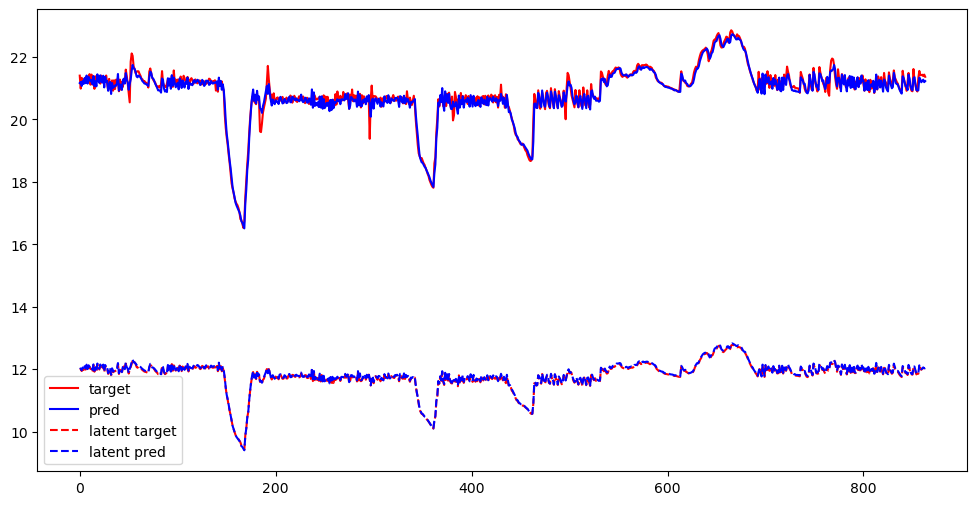

In [72]:
plt.figure(figsize=(12,6))
plt.plot(t_train[:,:], 'r-', label='target')
plt.plot(y_pred[:,:], 'b-', label='pred')
plt.plot(zt_pred[:,:], 'r--',label='latent target')
plt.plot(z_pred[:,:], 'b--',label='latent pred')

plt.legend()

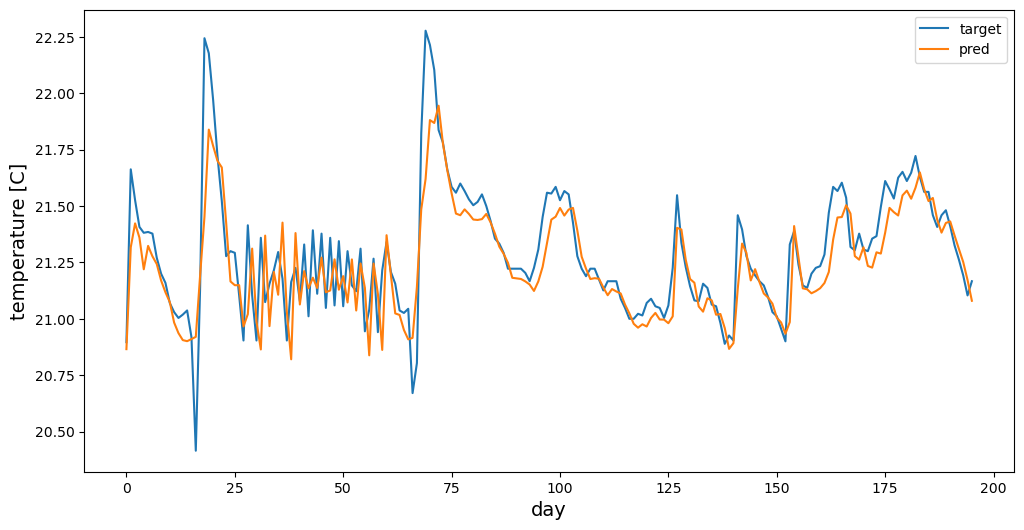

In [73]:
plt.figure(figsize=(12,6))
plt.plot(t_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.xlabel('day', fontsize=14)
plt.ylabel('temperature [C]', fontsize=14)
plt.legend()

In [60]:
train_state.params

{'params': {'Dense_0': {'bias': Array([ 0.        ,  0.        , -0.07904322,  0.2548927 , -0.06055277,
           0.35373893,  0.        , -0.09397157], dtype=float32),
   'kernel': Array([[ 0.00667535, -0.1422606 , -0.18205354, -0.04675898, -0.27765703,
            0.0534931 , -0.2643618 ,  0.25709805],
          [ 0.00876696, -0.03736693,  0.3987364 ,  0.09632209,  0.12938379,
           -0.10251934, -0.35198468, -0.33729947],
          [-0.00638604,  0.2673033 , -0.00861904,  0.17513312, -0.16712527,
           -0.2493489 , -0.23298226, -0.07488214],
          [-0.19071943, -0.17025793,  0.29419047, -0.31859943,  0.18105158,
            0.41319788,  0.2554262 , -0.03237235],
          [-0.36770746, -0.15340273, -0.31938213, -0.16594674,  0.11861873,
            0.14777356,  0.22600368, -0.4946264 ],
          [-0.29514736, -0.26557258, -0.209084  ,  0.00451992, -0.08896939,
            0.4274138 ,  0.24242957,  0.09908157],
          [ 0.11026152,  0.19384116,  0.28206176,  0.09023

## Physics-Consistent Check

How to know if the learned model follows general physics? 
- the derivative of room temp with respect to the HVAC energy rate should be positive. The more heat injected to the room, the higher the room temperature.

In [65]:
sample_index = [200]

prev_obs_fake = prev_obs_train[sample_index, :, :]
curr_obs_fake = curr_obs_train[sample_index, :]
u_fake = u_train[sample_index, :]
d_fake = d_train[sample_index, :]



In [66]:
# prepare faked inputs for physical simukation check
u = jnp.array([i for i in range(-10, 10)]).reshape(-1, 1) # (B, nu)
n_points = len(u)

prev_obs = jnp.tile(prev_obs_fake, (n_points, 1, 1)) # (B, n_lags, nx)
curr_obs = jnp.tile(curr_obs_fake, (n_points, 1)) # (B, nx)
d = jnp.tile(d_fake, (n_points, 1)) # (B, nd)

print(prev_obs.shape, curr_obs.shape, u.shape, d.shape)

(20, 8, 1) (20, 1) (20, 1) (20, 6)


In [67]:
z_pred, y_pred, z = model.apply(train_state.params, prev_obs, curr_obs, u, d)

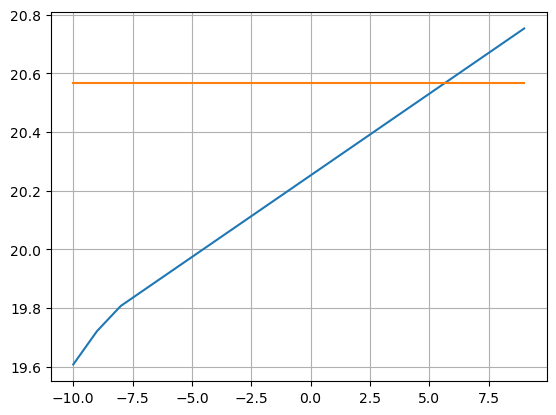

In [69]:
plt.figure()
plt.plot(u.squeeze(), y_pred, label='predicted room temp') #
plt.plot(u.squeeze(), curr_obs, label='previous room temp') # previous temperature
plt.grid()